In [1]:
!pip install nltk scikit-learn numpy pandas -q

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Data loading and understanding

In [3]:
#loading the dataset as pandas dataframe
df = pd.read_csv('/content/drive/MyDrive/DATA_SCIENCE_BIA/Datasets/movies.csv')

In [4]:
#showing the first 5 rows of the data
df.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


In [5]:
#checking the number of rows and columns in the data
df.shape

(4803, 24)

In [6]:
#checking detailed information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 4803 non-null   int64  
 1   budget                4803 non-null   int64  
 2   genres                4775 non-null   object 
 3   homepage              1712 non-null   object 
 4   id                    4803 non-null   int64  
 5   keywords              4391 non-null   object 
 6   original_language     4803 non-null   object 
 7   original_title        4803 non-null   object 
 8   overview              4800 non-null   object 
 9   popularity            4803 non-null   float64
 10  production_companies  4803 non-null   object 
 11  production_countries  4803 non-null   object 
 12  release_date          4802 non-null   object 
 13  revenue               4803 non-null   int64  
 14  runtime               4801 non-null   float64
 15  spoken_languages     

Here we can see there are 24 features in which 8 are numerical columns and 16 are categorical.

In [7]:
#filtering the required contents for prediction
required_content = ['genres','keywords','title','overview']

df = df[required_content]

In [8]:
df.head(2)

,genres,keywords,title,overview
0,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,Avatar,"In the 22nd century, a paraplegic Marine is di..."
1,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha..."


In [9]:
#checking missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   genres    4775 non-null   object
 1   keywords  4391 non-null   object
 2   title     4803 non-null   object
 3   overview  4800 non-null   object
dtypes: object(4)
memory usage: 150.2+ KB


Our dataframe shape is (4803, 5)

There are missing values in 'genres', 'keywords', 'overview', 'cast'. Since the missing values aren't huge dropping the missing values can be considered.

In [10]:
#dropping the missing values
df = df.dropna().reset_index(drop=True)

In [11]:
#cross checking the drop
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4387 entries, 0 to 4386
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   genres    4387 non-null   object
 1   keywords  4387 non-null   object
 2   title     4387 non-null   object
 3   overview  4387 non-null   object
dtypes: object(4)
memory usage: 137.2+ KB


In [12]:
#combining the data in 'genres' 'keywords' 'overview'
df['combined'] = df['genres'] + '' + df['keywords'] + '' + df['overview']

In [13]:
df.head(2)

,genres,keywords,title,overview,combined
0,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,Avatar,"In the 22nd century, a paraplegic Marine is di...",Action Adventure Fantasy Science Fictioncultur...
1,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",Adventure Fantasy Actionocean drug abuse exoti...


In [14]:
#filtering the required featured in variable called data
data = df[['title','combined']]

In [15]:
#creating wordcloud for movie content
combined_text = " ".join(df['combined'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

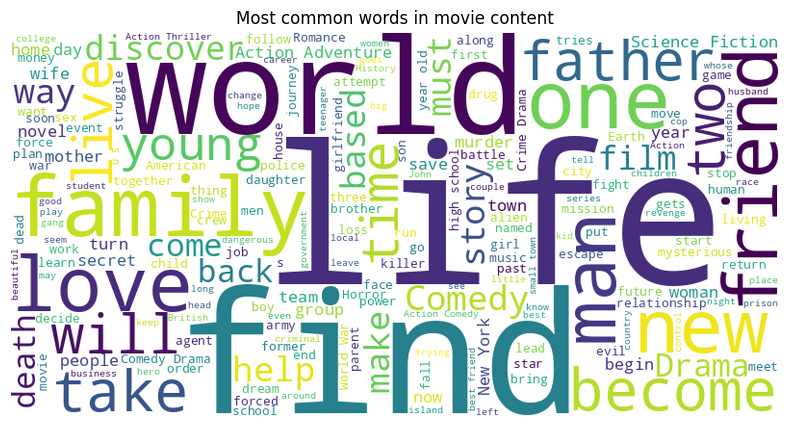

In [16]:
#using wordcloud to visualize the most common words in the movie content
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='blackman')
plt.axis('off')
plt.title('Most common words in movie content')
plt.show()

In [17]:
#downloading nltk data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
#setting the stop words and creating a set, since a set datatype can't have duplicate values
stop_words = set(stopwords.words('english'))

In [19]:
def preprocess_text(text):
  #remove speacial characters and numbers
  text = re.sub(r"[a-zA-Z]"," ",text)
  #converting to lower case
  text = text.lower()
  #tokenize and remove stop words
  tokens = word_tokenize(text)
  tokens = [word for word in tokens if not word in stop_words]
  return ''.join(tokens)

In [20]:
#applying preprocess to the movie content
data['cleaned_text'] = data['combined'].apply(preprocess_text)

<ipython-input-20-35748263a9b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cleaned_text'] = data['combined'].apply(preprocess_text)


In [21]:
#cross checking the preprocessing
data.head()

,title,combined,cleaned_text
0,Avatar,Action Adventure Fantasy Science Fictioncultur...,"22,,."
1,Pirates of the Caribbean: At World's End,Adventure Fantasy Actionocean drug abuse exoti...,"',,.."
2,Spectre,Action Adventure Crimespy based on novel secre...,"6’.,."
3,The Dark Knight Rises,Action Crime Drama Thrillerdc comics crime fig...,",''.,,'.."
4,John Carter,Action Adventure Science Fictionbased on novel...,"-,'().',."


In [22]:
#vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_text'])

Here we are finding the top 5000 words with some value and context using TfidfVectorizer and creating a vector of the 'cleaned_text'

In [23]:
#computing the cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [24]:
#Recommendation function
def recommend_movies(movie_name, cosine_sim = cosine_sim, df = data, top_n=5):
  #find the index of the movie
  index_movie = df[df['title'].str.lower() == movie_name.lower()].index
  if len(index_movie) == 0:
    return 'Movie not found in the database'
  index_movie = index_movie[0]

  #get similarity scores
  sim_scores = list(enumerate(cosine_sim[index_movie]))
  sim_scores = sorted(sim_scores, key=lambda x:x[1], reverse=True)
  sim_scores = sim_scores[1:top_n+1]

  #Get movie indices
  movie_indices = [i[0] for i in sim_scores]

  #Return top n similar movies
  return df['title'].iloc[movie_indices]

In [25]:
data['title']

,title
0,Avatar
1,Pirates of the Caribbean: At World's End
2,Spectre
3,The Dark Knight Rises
4,John Carter
...,...
4382,Bang
4383,Primer
4384,El Mariachi
4385,"Signed, Sealed, Delivered"


In [26]:
row_index = df[df['title'] == 'Batman v Superman: Dawn of Justice'].index
print(row_index)

Index([9], dtype='int64')


In [27]:
movie_name = data['title'][7]
print(movie_name)

Avengers: Age of Ultron


In [28]:
#Example recommendation
print(f"recommendations for the movie {movie_name}")
recommendations = recommend_movies(movie_name)
print(recommendations)

recommendations for the movie Avengers: Age of Ultron
1    Pirates of the Caribbean: At World's End
2                                     Spectre
3                       The Dark Knight Rises
4                                 John Carter
5                                Spider-Man 3
Name: title, dtype: object
